In [1]:
%pylab inline
import numpy as np
import pylab as pb
import GPy
import urllib
np.random.seed(2)

Populating the interactive namespace from numpy and matplotlib


## Hierachical Gaussian Process Example
This is a simple example of a hierachical GP over a toy data set, the theory to do this is in  http://www.biomedcentral.com/1471-2105/14/252

Initially we generate a simple sinusoidal signal, which for our undertsanding is the parent signal.

### Generating the parent signal

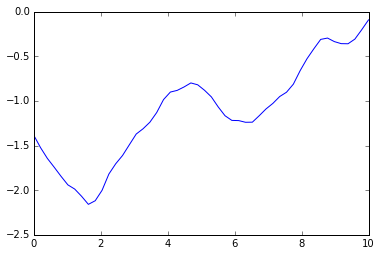

In [79]:
time_stamps = 50
x_parent = np.linspace(0, 10, time_stamps)
# generationg the parent form a GP sample
kg = GPy.kern.Matern32(input_dim=1, variance=1.0, lengthscale=4.0)
#inp = np.arange(x_parent.shape[0])
inp = x_parent[:, None]
C_parent_gen = kg.K(inp, None)
g_mean = np.zeros(x_parent.shape[0])
g_n = np.random.multivariate_normal(g_mean, C_parent_gen, 1)
g_n = np.squeeze(g_n)
pb.plot(x_parent, g_n)

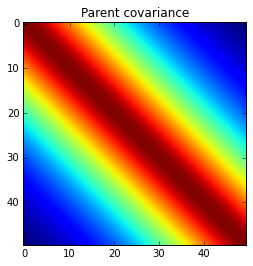

In [80]:
plt.imshow(C_parent_gen)
plt.title('Parent covariance')

The we generate noise corrupted signals which are like "sons" from the original signal, to do this we only add to the original signal some  gaussian noise with mean zero and a standard deviation. We expect to recover the original signal using these as an input.

### Generating the child signals

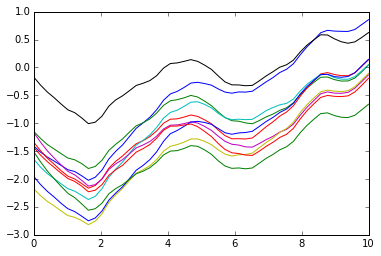

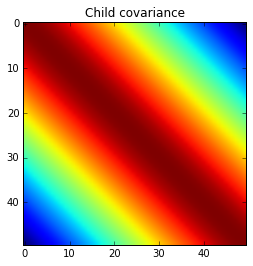

In [81]:
n_sons = 10
fn_list = []
kf = GPy.kern.Matern32(input_dim=1, variance=.1, lengthscale=10.0) + GPy.kern.Matern32(input_dim=1, variance=.09, lengthscale=8.0)
C_sons_gen = kf.K(inp, None)
plt.figure(1)
for i in range(0, n_sons):
    tmp = np.random.multivariate_normal(g_n, C_sons_gen, 1)
    tmp = np.squeeze(tmp)
    fn_list.append(tmp)
    plt.plot(inp, tmp)

plt.figure(2)
plt.imshow(C_sons_gen)
plt.title('Child covariance')

The samples can be also generated simultaneosly marginalizing out the parent

In [63]:
def genSamplesSimul(kg, kf, inp, n_sons=3):
    T_hat = np.r_[np.c_[inp, np.zeros_like(inp)]]
    for i in range(1,n_sons):
        T_hat = np.r_[T_hat, np.c_[inp, np.ones_like(inp)*i]]
        
    HGP_gen = GPy.kern._src.independent_outputs.Hierarchical(kernels=[kg,kf])
    HGP_cov_gen = HGP_gen.K(T_hat, None)
    plt.figure(1)
    plt.imshow(HGP_cov_gen)
    sample = np.random.multivariate_normal(np.zeros(T_hat.shape[0]), HGP_cov_gen)
    y_list = []
    plt.figure(2)
    for r in range(0,n_sons):
        index = T_hat[:,1]==r
        y_list.append(sample[index])
        plt.plot(inp, sample[index])
    return y_list

Given the documentation, the way to consruct a Hierarchical Kernel to compute a hierarchical covariance one need to use GPy.kern._src.independent_outputs.Hierarchical(kernels), Which receives as an input a list of kernels, the size of that list indicates the deepest level of that hierarchy, for these case we only have one level or layer.

The input to the regression is:
* T_hat: all data in the input space as a column vector with an extra column indicating the corresponding output
* y_hat: all data in the output space(sinusoidal corrupted signal) as a column vector.
* HGP: Hierarchical Kernel

Documentation(Code): https://github.com/SheffieldML/GPy/blob/devel/GPy/kern/src/independent_outputs.py 

In [71]:
T_hat = np.r_[np.c_[inp, np.zeros_like(inp)]]
#fn_list = genSamplesSimul(kg, kf, inp, n_sons)
Y_hat = np.r_[np.c_[fn_list[0]]]
for i in range(1,n_sons):
    T_hat = np.r_[T_hat, np.c_[inp, np.ones_like(inp)*i]]
    Y_hat = np.r_[Y_hat, np.c_[fn_list[i]]]
    
k1 = GPy.kern.Matern32(1, variance=5., lengthscale=20.) # Kernel for the underlying trend
k2 = GPy.kern.Matern32(1, variance=2., lengthscale=10.) #+ GPy.kern.White(1, variance=0.1) # Kernel for the layer of noise corrupted signals
#kernels = [k1,k2] 
HGP = GPy.kern._src.independent_outputs.Hierarchical(kernels=[k1,k2])

In [72]:
model = GPy.models.GPRegression(T_hat, Y_hat, HGP) # Making a normal regression
#print 'Model before op', model
#print 'hier kern before op', HGP
model.optimize('bfgs')#, messages=1)
#print 'Model after op', model
#print 'hier kern after op', HGP

In [73]:
model.optimize_restarts(num_restarts = 20)

Optimization restart 1/20, f = -1706.1712398
Optimization restart 2/20, f = -1706.38723023
Optimization restart 3/20, f = -1653.05642642
Optimization restart 4/20, f = -1572.09558909
Optimization restart 5/20, f = -1707.83173295
Optimization restart 6/20, f = -1698.86162777
Optimization restart 7/20, f = -1708.13852444
Optimization restart 8/20, f = -1707.6060147
Optimization restart 9/20, f = -1708.08968403
Optimization restart 10/20, f = -1705.23896973
Optimization restart 11/20, f = -1706.82366548
Optimization restart 12/20, f = -1516.72021875
Optimization restart 13/20, f = -1630.02636402
Optimization restart 14/20, f = -1707.79071129
Optimization restart 15/20, f = -1667.64458896
Optimization restart 16/20, f = -1706.62324469
Optimization restart 17/20, f = -1676.52441503
Optimization restart 18/20, f = -1573.9260256
Optimization restart 19/20, f = -1708.18233993
Optimization restart 20/20, f = -1708.03060248


Inferring the posterior over the underlying function.

In [74]:
print k1
mu, mvar = model.predict(inp, kern=k1, full_cov=True)
diag_var = np.diag(mvar)
#model.hierarchy.Mat32_1.variance = kg.variance
#model.hierarchy.Mat32_1.lengthscale = kg.lengthscale
#model.hierarchy.Mat32.variance = kf.variance
#model.hierarchy.Mat32.lengthscale = kf.lengthscale
#print k1

  Mat32_1.     |      Value      |  Constraint  |  Prior  |  Tied to
  variance     |  1.07021867901  |     +ve      |         |         
  lengthscale  |  3.84482309223  |     +ve      |         |         


### Predicting the upper layer
Ploting the mean of the posterior for the upper layer

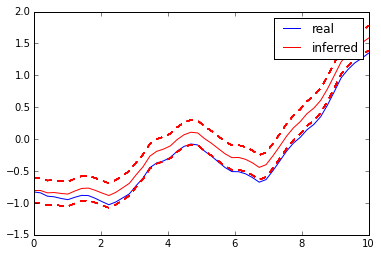

In [75]:
#mu2, mvar2 = model.predict(inp, kern=k1, full_cov=True)
#pb.plot(inp, g_n)
#pb.plot(inp, mu)
#pb.plot(inp, mu2)
blue_line, = pb.plot(inp, g_n, 'b-')
red_line, = pb.plot(inp, mu, 'r-')
pb.plot(inp, mu + 2*np.sqrt(diag_var), 'r--')
pb.plot(inp, mu - 2*np.sqrt(diag_var), 'r--')
plt.legend([blue_line, (blue_line, red_line)], ["real", "inferred"])

Covariance of the posterior for the upper layer

  Mat32_1.     |      Value      |  Constraint  |  Prior  |  Tied to
  variance     |  1.07021867901  |     +ve      |         |         
  lengthscale  |  3.84482309223  |     +ve      |         |         


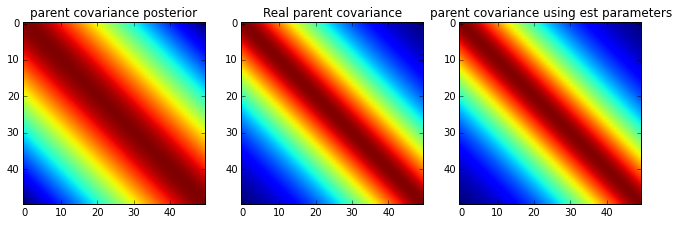

In [78]:
mtmp = k1.K(inp, None)
print k1
plt.figure(1, figsize=(15,6))
plt.subplot(1,4,1)
plt.title('parent covariance posterior')
plt.imshow(mvar)
#plt.subplot(1,4,2)
#plt.title('parent cov with origin params')
#plt.imshow(mvar2)
plt.subplot(1,4,2)
plt.title('Real parent covariance')
plt.imshow(C_parent_gen)
plt.subplot(1,4,3)
plt.title('parent covariance using est parameters')
plt.imshow(mtmp)

Plotting the model fitting

## Deeper Hierarchies with Hierarchical GPs

First, some kernels are added to generate the data.

In [91]:
time_stamps = 50
n_sons = 3
# following a similar nomenclature used by hensman et al.
k_cluster_gen = GPy.kern.Matern32(1, variance=1.5, lengthscale=5.)
k_parent_gen = GPy.kern.Matern32(1, variance=.1, lengthscale=2.5)
k_replicate_gen = GPy.kern.Matern32(1, variance=.01, lengthscale=1.5)

Then the upperlayer is generated.

In [92]:
x_parent = np.linspace(0, 10, time_stamps)
inp = x_parent[:, None]
C_cluster_gen = k_cluster_gen.K(inp, None)
g_mean = np.zeros(x_parent.shape[0])
g_n = np.random.multivariate_normal(g_mean, C_cluster_gen, 1)
g_n = np.squeeze(g_n)

The second layer is added 

In [93]:
fn_list = []
C_parent_gen = k_parent_gen.K(inp, None)
for i in range(0, n_sons):
    tmp = np.random.multivariate_normal(g_n, C_parent_gen, 1)
    tmp = np.squeeze(tmp)
    fn_list.append(tmp)

The third layer is added.

In [104]:
hn_list = []
n_replicates = 9
C_replicate_gen = k_replicate_gen.K(inp, None)
for i in range(0, n_sons):
    for k in range(0, n_replicates):
        tmp = np.random.multivariate_normal(fn_list[i], C_replicate_gen, 1)
        tmp = np.squeeze(tmp)
        hn_list.append(tmp)

Arranging the data

In [105]:
T_hat = np.c_[inp, np.zeros_like(inp), np.zeros_like(inp)]
Y_hat = np.r_[np.c_[hn_list[0]]]
for i in range(1, n_replicates):
    T_hat = np.r_[T_hat, np.c_[inp, np.zeros_like(inp), np.ones_like(inp)*i]]
    Y_hat = np.r_[Y_hat, np.c_[hn_list[i]]]

count_gene = 1
count_replicate = n_replicates
#print Y_hat
for i in range(3,len(hn_list)):
    if(count_replicate%n_replicates == 0 and count_replicate != 0):
        count_gene += 1
    T_hat = np.r_[T_hat, np.c_[inp, np.ones_like(inp)*count_gene, np.ones_like(inp)*count_replicate]]
    Y_hat = np.r_[Y_hat, np.c_[hn_list[i]]]
    count_replicate += 1

k1 = GPy.kern.Matern32(1, variance=5., lengthscale=20.) # Kernel for the underlying trend
k2 = GPy.kern.Matern32(1, variance=2., lengthscale=10.) 
k3 = GPy.kern.Matern32(1, variance=1., lengthscale=10.) 
HGP = GPy.kern._src.independent_outputs.Hierarchical(kernels=[k1,k2,k3])

Creating the GP Model

In [106]:
model = GPy.models.GPRegression(T_hat, Y_hat, HGP) # Making a normal regression
model.optimize('bfgs')#, messages=1)

### Predicting the underlying trend

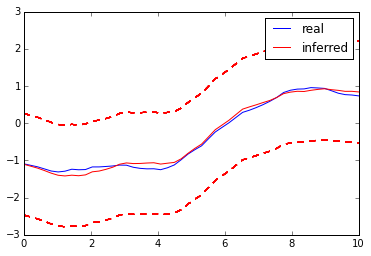

In [107]:
mu, mvar = model.predict(inp, kern=k1, full_cov=True)
diag_var = np.diag(mvar)
blue_line, = pb.plot(inp, g_n, 'b-')
red_line, = pb.plot(inp, mu, 'r-')
pb.plot(inp, mu + 2*np.sqrt(diag_var), 'r--')
pb.plot(inp, mu - 2*np.sqrt(diag_var), 'r--')
plt.legend([blue_line, (blue_line, red_line)], ["real", "inferred"])

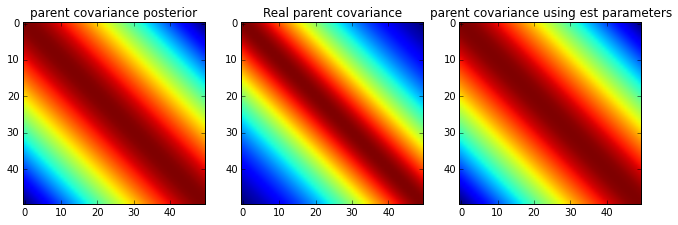

In [108]:
mtmp = k1.K(inp, None)
plt.figure(1, figsize=(15,6))
plt.subplot(1,4,1)
plt.title('parent covariance posterior')
plt.imshow(mvar)
plt.subplot(1,4,2)
plt.title('Real parent covariance')
plt.imshow(C_cluster_gen)
plt.subplot(1,4,3)
plt.title('parent covariance using est parameters')
plt.imshow(mtmp)